# Multiple Linear Regression using Neural Network

NOTE: Tensor operations are performed on GPU using CUDA

#### 1. Loading data, modules, data preprocessing

In [1]:
import torch
import numpy as np
import pandas as pd

cuda = torch.device('cuda')
dataset = pd.read_csv('50_Startups.csv')

dummies = pd.get_dummies(dataset['State'], drop_first = True)
dataset = pd.merge(dataset, dummies, left_index = True, right_index = True)
dataset = dataset.drop('State', axis = 1)

training_data = dataset.sample(frac = 0.75)
test_data = dataset.drop(index = training_data.index)

mean = training_data.mean()
sd = training_data.std()

training_data = (training_data - mean) / sd
test_data = (test_data - mean) / sd

x_train = training_data.drop('Profit', axis = 1)
y_train = training_data['Profit']

x_test = test_data.drop('Profit', axis = 1)
y_test = test_data['Profit']

x_train.head()

,R&D Spend,Administration,Marketing Spend,Florida,New York
23,-0.235069,-0.459936,0.728872,1.452463,-0.670368
46,-1.763618,-0.121137,0.663525,1.452463,-0.670368
20,-0.033747,-0.186738,0.676758,-0.670368,-0.670368
42,-1.248259,-0.781777,-0.609506,-0.670368,-0.670368
11,0.529919,-0.929850,0.259112,-0.670368,-0.670368


In [2]:
y_train.head()

23   -0.141201
46   -1.631391
20    0.103797
42   -1.077814
11    0.752396
Name: Profit, dtype: float64

#### 2. Neural Net Design

In [0]:
class Network():

    def __init__(self, layers = [1, 1]):
        self.w = []
        for i in range(len(layers)-1):
            self.w.append(torch.rand(layers[i], layers[i+1], 
                                     device = cuda,
                                     requires_grad = True))

    def train(self, x, y, epochs = 100, learning_rate = 0.01):
        losses = []
        for e in range(1, epochs + 1):
            x_train = torch.from_numpy(x.values).float().to(cuda)
            y_train = torch.from_numpy(y.values.reshape(-1, 1)).float().to(cuda)

            y_pred = x_train.mm(self.w[0])
            for i in range(1, len(self.w)):
                y_pred = y_pred.mm(self.w[i])
            loss = (y_train - y_pred).pow(2).sum()
            losses.append(loss)
            # print('Epoch {} of {}, loss = {}'.format(e, epochs, loss.item()))
            loss.backward()
            with torch.no_grad():
                for weight in self.w:
                    weight -= weight.grad * learning_rate
                    weight.grad.zero_()
        return losses

    def pred(self, x):
        predx = torch.from_numpy(x.values).float().to(cuda)
        y_pred = predx.mm(self.w[0])
        for i in range(1, len(self.w)):
            y_pred = y_pred.mm(self.w[i])
        return y_pred.detach().cpu().numpy()

#### 3. Initializing and training the net

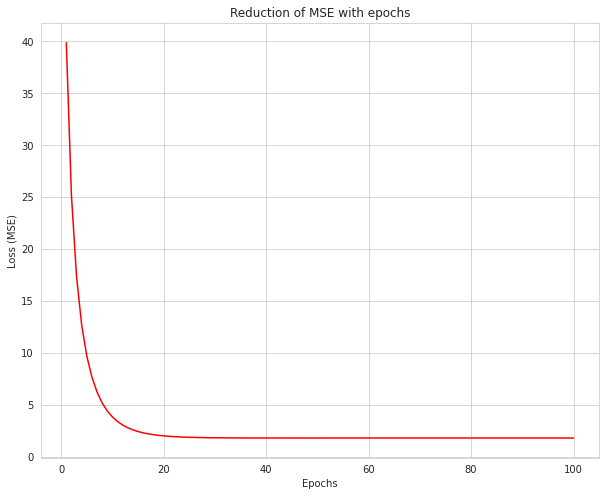

In [19]:
x_train['Bias'] = 1
x_test['Bias'] = 1

network = Network([6, 1])
losses = network.train(x_train, y_train)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

plt.figure(figsize = (10, 8));
plt.plot(np.arange(1, 101), losses, c = 'red');
plt.xlabel('Epochs'); plt.ylabel('Loss (MSE)');
plt.title('Reduction of MSE with epochs');

#### 4. Predictions and end results

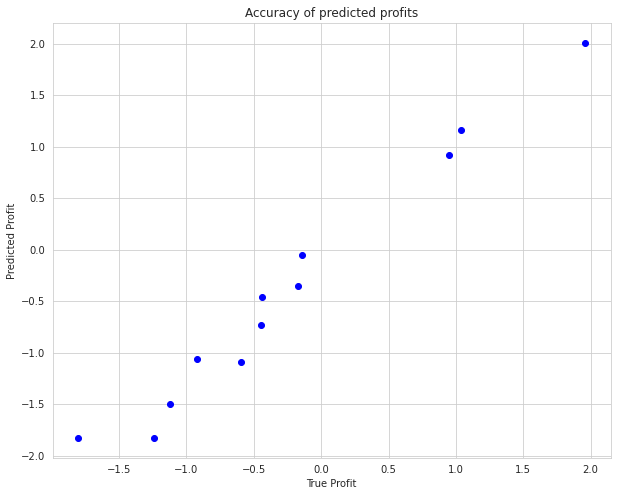

In [20]:
y_pred = network.pred(x_test)

plt.figure(figsize = (10, 8));
plt.scatter(y_test, y_pred, c = 'blue');
plt.xlabel('True Profit'); plt.ylabel('Predicted Profit');
plt.title('Accuracy of predicted profits');

In [21]:
print('MSE = {}'.format(((y_test.ravel() - y_pred.ravel())**2).sum()))

MSE = 0.8759609087172966
